**Explorando Streaming e Orquestração de Estados com LangGraph: Um Mergulho Técnico**

O script abaixo exibe um cenário riquíssimo de como o **LangGraph** gerencia e “streama” (emite gradualmente) o estado de uma aplicação de IA conversacional, reforçando a ideia de que cada nó do grafo pode fornecer saídas parciais ou finais à medida que a execução avança. A seguir, vamos explorar os principais conceitos técnicos envolvidos, enfatizando como o LangGraph organiza a transição de estados, lida com tokens de modelos de linguagem e mantém um fluxo coerente.

---

## 1. StateGraph e Modelagem de Fluxo

No LangGraph, um **StateGraph** define a estrutura e a evolução do estado de uma aplicação.  
- **Nós (Nodes)**: São funções (pontos de processamento) responsáveis por transformar ou analisar o estado. No script, aparecem exemplos como `chamar_modelo` e `resumir_conversa`.  
- **Arestas (Edges)**: Definem a transição entre nós. Quando adicionamos um `START` ou `END`, deixamos explícito onde o grafo inicia e finaliza o processamento.  
- **Estados (State)**: Aqui, a classe `Estado(MessagesState)` estende uma estrutura que lida com mensagens e adiciona o atributo `resumo`. Em termos matemáticos, podemos considerar o “estado” como \( s \in S \), que representa a configuração interna do sistema em cada etapa. Cada nó aplica uma função \( f: S \to S \), transformando o estado.

A ideia de **transição de estados** se assemelha a autômatos de estados finitos ou mesmo a **M**áquinas de Moore/Mealy, em que cada nó pode atualizar o estado com base na entrada corrente (mensagens, histórico, resumo, etc.) e produzir uma saída (resposta do modelo).  

---

## 2. Memória e Checkpointing

- **MemorySaver**: O script utiliza `MemorySaver` como “checkpointer”. Isso significa que, sempre que o fluxo avança, o estado pode ser persistido. Em termos práticos, esse comportamento permite “recuperar” conversas anteriores, gerenciando histórico e evitando perda de dados.  
- **Resumo de Conversa**: A função `resumir_conversa` demonstra como o LangGraph pode condensar o histórico em um resumo (uma forma de compressão semântica). Esse tipo de abordagem tem ligação com modelos de “estado condensado”, em que reduzimos dimensionalidade ou tamanho do histórico para manter o sistema escalável.

Matematicamente, podemos enxergar o resumo como um mapeamento \( \operatorname{Resumir}: (M_1, M_2, \ldots, M_n) \to R \), onde \(R\) é uma versão condensada do conjunto de mensagens \( \{M_i\} \). A cada iteração, esse resumo pode ser estendido.

---

## 3. Streaming: Atualizações, Valores e Tokens

O LangGraph suporta diferentes **modos de streaming**. Esses modos controlam quais pedaços do estado são emitidos e em qual frequência. Vejamos os principais demonstrados no notebook:

1. **stream\_mode="updates"**  
   - Cada atualização do grafo é transmitida. Por exemplo, após cada nó, obtemos um “chunk” representando a porção atualizada do estado.  
   - Pensando em termos matemáticos, é como se observássemos a função \( f_i(s) \) a cada nó \(i\), capturando a transformação incremental do estado \( s \) até o final do fluxo.

2. **stream\_mode="values"**  
   - Foca nos valores resultantes (por exemplo, a lista de mensagens atualizadas) em cada etapa. Pode ser útil para debugar “passo a passo” como o estado evolui.  
   - Nesse caso, estamos interessados nas variáveis do estado após cada aplicação de função no grafo, quase como ver a sequência \( (s_0, s_1, s_2, \ldots) \) ao longo das arestas.

3. **astream\_events(version="v2")**  
   - Emite “eventos” detalhados, incluindo tokens sendo gerados (token streaming). Cada token parcial do modelo de linguagem é enviado em tempo real, além de metadados como `tool_calls` e `metadata`.  
   - Isso lembra a ideia de “observabilidade” durante a execução de um processo markoviano. Cada token é como um passo intermediário em que a saída do modelo ainda não está completa, mas já podemos acompanhá-la.

4. **Filtragem de eventos**  
   - O código mostra exemplos de filtragem, como exibir apenas tokens de um nó específico (`no_para_stream = 'conversa'`). Isso permite granularidade fina: podemos, por exemplo, monitorar apenas as saídas textuais de um ponto crítico do fluxo.

---

## 4. Human-in-the-Loop e Lógica de Parada

O script aborda a motivação para “streaming” antes de introduzir o **human-in-the-loop**. No LangGraph, a intervenção humana pode acontecer de diversas formas:

- **Ver o estado intermediário**: O streaming permite que uma pessoa ou outro sistema veja, token a token ou chunk a chunk, o que está sendo gerado.  
- **Desvio Condicional**: A função `deve_continuar(estado)` exemplifica um “condicional” que encaminha para `resumir_conversa` se a conversa excede determinado número de mensagens. De forma análoga, poderíamos interromper a execução para aguardar input humano ou seguir um caminho alternativo.

Em termos matemáticos, cada condicional é uma função \( c(s) \) que escolhe qual transição \( t \) será seguida, com base em critérios do estado (tamanho de mensagens, presença de contexto, etc.). É como ter várias funções \( f \) possíveis, mas apenas uma é selecionada para cada estado.  

---

## 5. Ferramentas e Tool Calls

Em algumas partes do script, observamos a formatação de “tool calls”. Esse conceito remete a quando o modelo chama ferramentas externas (por exemplo, buscadores, calculadoras, bancos de dados). O LangGraph, ao lidar com **eventos de streaming**, pode:

- Incluir no chunk de resposta do modelo um trecho JSON (ou outro formato) indicando uma chamada de ferramenta.  
- Expor esses “tool calls” para que um supervisor humano ou outro agente processe a ação requisitada.

Isso demonstra que o LangGraph não se limita apenas a fluxo de mensagens; ele gerencia *toda* a dinâmica do agente (ferramentas, chamadas externas, etc.) durante a execução.

---

## 6. Relação com Autômatos e Processos de Markov

Como cada nó é uma etapa de transformação no estado, podemos enxergar o grafo como um **autômato** onde:
- O estado \( s \) é atualizado por uma função \( f_n \) correspondente ao nó \( n \).  
- O `MemorySaver` atua como um “buffer” de histórico, reter ou condensar as transições passadas.  
- O streaming ocorre durante a aplicação de cada função, fornecendo uma visão **intra-execução** do autômato.

Esse fluxo também guarda semelhança com um **Processo de Decisão Markoviano** (MDP), em que o estado evolui com base na ação escolhida (por exemplo, “resumir conversa” vs. “encerrar”), embora aqui as “ações” sejam nós que o sistema escolhe, possivelmente influenciado por heurísticas ou checagens de condição.

---

## 7. Conclusão

Neste notebook, vemos o **LangGraph** alavancando conceitos de grafos dirigidos, checagem de estado, condicionais e streaming para construir aplicações conversacionais de forma **modular** e **observável**:

1. **Orquestração**: Cada nó é uma transformação funcional, e as arestas definem as transições de estado.  
2. **Persistência**: O `MemorySaver` viabiliza reter o estado em memória ou armazená-lo de forma persistente, permitindo conversas mais longas ou complexas.  
3. **Streaming**: Diferentes modos oferecem granularidade em tempo real do que está acontecendo, desde atualizações de estado até a geração token a token do modelo.  
4. **Condicionais**: Funções como `deve_continuar` demonstram tomada de decisão durante a execução do grafo, em vez de ter um único fluxo linear.  
5. **Integração de Ferramentas**: A formatação de “tool calls” e a possibilidade de exibir cada evento reforçam como a arquitetura do LangGraph consegue gerenciar **IA baseada em agentes** (Agents) que chamam funções externas sob demanda.

Para projetos de IA mais robustos, entender esses blocos — estado, nós, arestas, nós condicionais, ferramenta de streaming — permite criar pipelines interativos, escaláveis e auditáveis, onde cada transição pode ser analisada, inspecionada e customizada. Do ponto de vista matemático e de engenharia de software, esse grau de **orquestração declarativa** facilita a expansão futura, inclusão de novos comportamentos e até adoção de paradigmas como *human-in-the-loop* ou *auto-curation* de dados e modelos.

In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

O LangGraph é construído com [suporte de primeira classe para streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Vamos configurar nosso Chatbot do Módulo 2 e mostrar várias maneiras de transmitir as saídas do grafo durante a execução.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

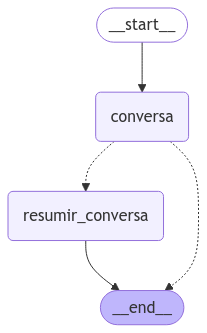

In [4]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
modelo = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

# Estado 
class Estado(MessagesState):
    resumo: str

# Define a lógica para chamar o modelo
def chamar_modelo(estado: Estado):
    
    # Obtém o resumo se existir
    resumo = estado.get("summary", "")

    # Se existe um resumo, então o adicionamos
    if resumo:
        
        # Adiciona resumo à mensagem do sistema
        mensagem_sistema = f"Resumo da conversa anterior: {resumo}"

        # Anexa o resumo a quaisquer mensagens mais novas
        mensagens = [SystemMessage(content=mensagem_sistema)] + estado["messages"]
    
    else:
        mensagens = estado["messages"]
    
    resposta = modelo.invoke(mensagens)
    return {"messages": resposta}

def resumir_conversa(estado: Estado):
    
    # Primeiro, obtemos qualquer resumo existente
    resumo = estado.get("summary", "")

    # Cria nosso prompt de resumo 
    if resumo:
        
        # Já existe um resumo
        mensagem_resumo = (
            f"Este é o resumo da conversa até agora: {resumo}\n\n"
            "Estenda o resumo levando em conta as novas mensagens acima:"
        )
        
    else:
        mensagem_resumo = "Crie um resumo da conversa acima:"

    # Adiciona o prompt ao nosso histórico
    mensagens = estado["messages"] + [HumanMessage(content=mensagem_resumo)]
    resposta = modelo.invoke(mensagens)
    
    # Exclui todas as mensagens exceto as 2 mais recentes
    excluir_mensagens = [RemoveMessage(id=m.id) for m in estado["messages"][:-2]]
    return {"summary": resposta.content, "messages": excluir_mensagens}

# Determina se deve encerrar ou resumir a conversa
def deve_continuar(estado: Estado):
    
    """Retorna o próximo nó a ser executado."""
    
    mensagens = estado["messages"]
    
    # Se houver mais de seis mensagens, então resumimos a conversa
    if len(mensagens) > 6:
        return "resumir_conversa"
    
    # Caso contrário, podemos apenas encerrar
    return END

# Define um novo grafo
fluxo = StateGraph(Estado)
fluxo.add_node("conversa", chamar_modelo)
fluxo.add_node(resumir_conversa)

# Define o ponto de entrada como conversa
fluxo.add_edge(START, "conversa")
fluxo.add_conditional_edges("conversa", deve_continuar)
fluxo.add_edge("resumir_conversa", END)

# Compila
memoria = MemorySaver()
grafo = fluxo.compile(checkpointer=memoria)
display(Image(grafo.get_graph().draw_mermaid_png()))

### Streaming do estado completo

Agora, vamos falar sobre maneiras de [transmitir nosso estado do grafo](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` e `.astream` são métodos síncronos e assíncronos para transmitir resultados de volta.

O LangGraph suporta alguns [diferentes modos de streaming](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) para [estado do grafo](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):

* `values`: Transmite o estado completo do grafo após cada nó ser chamado.
* `updates`: Transmite as atualizações do estado do grafo após cada nó ser chamado.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Vamos ver o `stream_mode="updates"`.

Como transmitimos com `updates`, só vemos atualizações do estado após cada nó no grafo ser executado.

Cada `chunk` é um dicionário com `node_name` como chave e o estado atualizado como valor.

In [5]:
# Cria um thread
config = {"configurable": {"thread_id": "1"}}

# Inicia a conversa
for chunk in grafo.stream({"messages": [HumanMessage(content="Olá! Sou Anderson")]}, config, stream_mode="updates"):
    print(chunk)

{'conversa': {'messages': AIMessage(content='Olá, Anderson! Como posso ajudá-lo hoje?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 11, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-45f75ab7-2205-435a-9f49-e4108d09c78b-0', usage_metadata={'input_tokens': 11, 'output_tokens': 11, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Vamos agora apenas imprimir a atualização do estado.


In [6]:
# Inicia a conversa
for chunk in grafo.stream({"messages": [HumanMessage(content="Olá! Sou Anderson")]}, config, stream_mode="updates"):
    chunk['conversa']["messages"].pretty_print()

================================== Ai Message ==================================

Olá, Anderson! Como você está? O que posso fazer por você hoje?



Agora, podemos ver `stream_mode="values"`.

Este é o `estado completo` do grafo após o nó `conversa` ser chamado.

In [7]:
# Inicia a conversa novamente
config = {"configurable": {"thread_id": "2"}}

# Inicia a conversa
mensagem_entrada = HumanMessage(content="Olá! Sou Anderson")
for evento in grafo.stream({"messages": [mensagem_entrada]}, config, stream_mode="values"):
    for m in evento['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Olá! Sou Anderson
---------------------------------------------------------------------------
================================ Human Message =================================

Olá! Sou Anderson
================================== Ai Message ==================================

Olá, Anderson! Como posso ajudá-lo hoje?
---------------------------------------------------------------------------


### Streaming de tokens 

Frequentemente queremos transmitir mais do que apenas o estado do grafo.

Em particular, com chamadas do modelo de chat é comum transmitir os tokens conforme eles são gerados.

Podemos fazer isso [usando o método `.astream_events`](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), que transmite eventos conforme eles acontecem dentro dos nós!

Cada evento é um dicionário com algumas chaves:
 
* `event`: Este é o tipo de evento que está sendo emitido. 
* `name`: Este é o nome do evento.
* `data`: Estes são os dados associados ao evento.
* `metadata`: Contém `langgraph_node`, o nó que está emitindo o evento.

Vamos dar uma olhada.

In [8]:
config = {"configurable": {"thread_id": "3"}}
mensagem_entrada = HumanMessage(content="Me fale sobre a seleção brasileira de futebol de 2002")
async for evento in grafo.astream_events({"messages": [mensagem_entrada]}, config, version="v2"):
    print(f"Nó: {evento['metadata'].get('langgraph_node','')}. Tipo: {evento['event']}. Nome: {evento['name']}")

Nó: . Tipo: on_chain_start. Nome: LangGraph
Nó: __start__. Tipo: on_chain_start. Nome: __start__
Nó: __start__. Tipo: on_chain_start. Nome: _write
Nó: __start__. Tipo: on_chain_end. Nome: _write
Nó: __start__. Tipo: on_chain_start. Nome: _write
Nó: __start__. Tipo: on_chain_end. Nome: _write
Nó: __start__. Tipo: on_chain_stream. Nome: __start__
Nó: __start__. Tipo: on_chain_end. Nome: __start__
Nó: conversa. Tipo: on_chain_start. Nome: conversa
Nó: conversa. Tipo: on_chat_model_start. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: on_chat_model_stream. Nome: ChatOpenAI
Nó: conversa. Tipo: o

O ponto central é que os tokens dos modelos de chat dentro do seu grafo têm o tipo `on_chat_model_stream`.

Podemos usar `evento['metadata']['langgraph_node']` para selecionar o nó do qual queremos fazer o streaming.

E podemos usar `evento['data']` para obter os dados reais de cada evento, que neste caso é um `AIMessageChunk`. 

In [9]:
no_para_stream = 'conversa'
config = {"configurable": {"thread_id": "4"}}
mensagem_entrada = HumanMessage(content="Me fale sobre a seleção brasileira de futebol de 2002")
async for evento in grafo.astream_events({"messages": [mensagem_entrada]}, config, version="v2"):
    # Obtém tokens do modelo de chat de um nó específico
    if evento["event"] == "on_chat_model_stream" and evento['metadata'].get('langgraph_node','') == no_para_stream:
        print(evento["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-1eea82ef-8af5-46b9-aa52-331662e13ed7')}
{'chunk': AIMessageChunk(content='A', additional_kwargs={}, response_metadata={}, id='run-1eea82ef-8af5-46b9-aa52-331662e13ed7')}
{'chunk': AIMessageChunk(content=' Sele', additional_kwargs={}, response_metadata={}, id='run-1eea82ef-8af5-46b9-aa52-331662e13ed7')}
{'chunk': AIMessageChunk(content='ção', additional_kwargs={}, response_metadata={}, id='run-1eea82ef-8af5-46b9-aa52-331662e13ed7')}
{'chunk': AIMessageChunk(content=' Brasileira', additional_kwargs={}, response_metadata={}, id='run-1eea82ef-8af5-46b9-aa52-331662e13ed7')}
{'chunk': AIMessageChunk(content=' de', additional_kwargs={}, response_metadata={}, id='run-1eea82ef-8af5-46b9-aa52-331662e13ed7')}
{'chunk': AIMessageChunk(content=' Futebol', additional_kwargs={}, response_metadata={}, id='run-1eea82ef-8af5-46b9-aa52-331662e13ed7')}
{'chunk': AIMessageChunk(content=' de', additional_kwargs={}, resp

Como você pode ver acima, basta usar a chave `chunk` para obter o `AIMessageChunk`.

In [10]:
config = {"configurable": {"thread_id": "5"}}
mensagem_entrada = HumanMessage(content="Me fale sobre a seleção brasileira de futebol de 2002")
async for evento in grafo.astream_events({"messages": [mensagem_entrada]}, config, version="v2"):
    # Obtém tokens do modelo de chat de um nó específico
    if evento["event"] == "on_chat_model_stream" and evento['metadata'].get('langgraph_node','') == no_para_stream:
        dados = evento["data"]
        print(dados["chunk"].content, end="|")

|A| Sele|ção| Brasileira| de| Futebol| de| |200|2| é| lembr|ada| como| uma| das| melhores| equipes| da| história| do| futebol|,| especialmente| por| sua| performance| na| Copa| do| Mundo| da| FIFA| daquele| ano|,| realizada| na| Core|ia| do| Sul| e| no| Japão|.| Sob| o| comando| do| técnico| Luiz| Felipe| S|col|ari|,| o| Brasil| conquist|ou| seu| quinto| título| mundial|,| um| feito| in|édito| até| então|.

|###| Princip|ais| Caracter|ísticas| da| Sele|ção| de| |200|2|:

|1|.| **|El|enco| Est|elar|**|:| O| time| cont|ava| com| jogadores| de| alto| nível|,| como|:
|  | -| **|R|onal|do|**|:| O| atacante| foi| o| grande| destaque| da| competição|,| termin|ando| como| ar|til|heiro| com| |8| gols|,| incluindo| dois| na| final|.
|  | -| **|R|ival|do|**|:| Outro| atacante| de| destaque|,| que| também| teve| um| papel| crucial|,| marc|ando| gols| importantes| ao| longo| do| torne|io|.
|  | -| **|Ron|ald|inho| Ga|ú|cho|**|:| O| jovem| talento| que| se| destacou| com| sua| habilidade| e| criativ

Vamos [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), como antes.
V

O objeto transmitido tem:

* `event`: Tipo
* `data`: Estado

In [11]:
# Usando o grafo que já foi definido anteriormente
config = {"configurable": {"thread_id": "1"}}
mensagem_entrada = HumanMessage(content="Multiplique 2 e 3")

# Usando stream_mode="values" para ver o estado completo
async for evento in grafo.astream(
    {"messages": [mensagem_entrada]}, 
    config, 
    stream_mode="values"
):
    mensagens = evento.get('messages', None)
    if mensagens:
        for msg in mensagens:
            msg.pretty_print()
    print('='*25)

================================ Human Message =================================

Olá! Sou Anderson
================================== Ai Message ==================================

Olá, Anderson! Como posso ajudá-lo hoje?
================================ Human Message =================================

Olá! Sou Anderson
================================== Ai Message ==================================

Olá, Anderson! Como você está? O que posso fazer por você hoje?
================================ Human Message =================================

Multiplique 2 e 3


================================ Human Message =================================

Olá! Sou Anderson
================================== Ai Message ==================================

Olá, Anderson! Como posso ajudá-lo hoje?
================================ Human Message =================================

Olá! Sou Anderson
================================== Ai Message ==================================

Olá, Anderson! Como você está? O que posso fazer por você hoje?
================================ Human Message =================================

Multiplique 2 e 3
================================== Ai Message ==================================

2 multiplicado por 3 é igual a 6. Se precisar de mais alguma coisa, é só avisar!


Existem alguns novos modos de streaming que são suportados apenas via API.

Por exemplo, podemos [usar o modo `messages`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) para lidar melhor com o caso acima!

Este modo atualmente assume que você tem uma chave `messages` em seu grafo, que é uma lista de mensagens.

Todos os eventos emitidos usando o modo `messages` têm dois atributos:

* `event`: Este é o nome do evento
* `data`: Estes são os dados associados ao evento

In [12]:
# Usando o grafo existente
config = {"configurable": {"thread_id": "2"}}
mensagem_entrada = HumanMessage(content="Multiplique 2 e 3")

# Stream usando o modo messages
async for evento in grafo.astream_events(
    {"messages": [mensagem_entrada]}, 
    config, 
    version="v2"
):
    # Filtra apenas eventos do modelo de chat
    if evento["event"] == "on_chat_model_stream":
        print(evento["data"]["chunk"].content, end="")

A multiplicação de 2 e 3 é 6. Se precisar de mais alguma coisa, é só avisar!

Podemos ver alguns tipos de eventos:

* `metadata`: metadados sobre a execução
* `messages/complete`: mensagem completamente formada
* `messages/partial`: tokens do modelo de chat

Você pode explorar mais sobre os tipos [aqui](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Agora, vamos mostrar como fazer o streaming dessas mensagens.

Vamos definir uma função auxiliar para melhor formatação das chamadas de ferramentas nas mensagens.

In [13]:
# Usando o grafo existente
config = {"configurable": {"thread_id": "3"}}
mensagem_entrada = HumanMessage(content="Multiplique 2 e 3")

def format_tool_calls(tool_calls):
    """
    Formata uma lista de chamadas de ferramentas em uma string legível.
    """
    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for evento in grafo.astream_events(
    {"messages": [mensagem_entrada]}, 
    config, 
    version="v2"
):
    # Trata eventos de metadata
    if evento["event"] == "metadata":
        print(f"Metadata: Node - {evento['metadata'].get('langgraph_node', '')}")
        print("-" * 50)
    
    # Trata eventos do modelo de chat
    elif evento["event"] == "on_chat_model_stream":
        data = evento["data"]
        if "chunk" in data:
            content = data["chunk"].content
            print(f"AI: {content}", end="")
            
        # Se houver tool calls no chunk
        tool_calls = data.get("tool_calls", [])
        if tool_calls:
            print("\nTool Calls:")
            print(format_tool_calls(tool_calls))
            
    print("-" * 50)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
AI: --------------------------------------------------
AI: A--------------------------------------------------
AI:  multiplic--------------------------------------------------
AI: ação--------------------------------------------------
AI:  de--------------------------------------------------
AI:  --------------------------------------------------
AI: 2--------------------------------------------------
AI:  e--------------------------------------------------
AI:  -----------------------